In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pyjet import cluster,DTYPE_PTEPM
import fastjet as fj
import energyflow as ef
from tqdm import tqdm


# Pyjet

In [25]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [26]:
# Option 1: Load everything into memory
df = pandas.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [27]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [28]:
truth = np.array(df[2100])
print(truth.shape)
np.unique(truth,return_counts=True)

(1100000,)


(array([0., 1.]), array([1000000,  100000]))

In [29]:
events_combined_perm = np.array(df)[np.random.permutation(len(np.array(df)))]
print(np.shape(events_combined_perm))
#events_combined = events_combined[:, :10000]
#print(events_combined.shape)
print(events_combined_perm[:,2100])

(1100000, 2101)
[0. 0. 0. ... 0. 0. 0.]


In [30]:
events_combined = events_combined_perm[:10000]
print(np.unique(events_combined[:,2100],return_counts=True))
#events_combined = events_combined.T
#print(events_combined.shape)

(array([0., 1.]), array([9056,  944]))


In [31]:
phi = events_combined[:,::3]
print(phi.shape)
print(phi[0,:50])

(10000, 701)
[1.42892265e+00 1.88546753e+01 1.44286656e+00 2.00822639e+00
 5.11235762e+00 1.29668856e+00 1.16210854e+00 2.46102962e+01
 1.19334888e+03 1.78706951e+01 2.02429008e+00 2.81843615e+00
 4.91305828e+00 6.12278414e+00 2.40091648e+01 3.42726469e+00
 2.86559463e+00 3.72665954e+00 5.48907089e+00 1.16427708e+00
 1.23194039e+00 4.59656239e+00 2.97817492e+00 1.55548487e+01
 4.34041481e+01 2.49011564e+00 5.45455837e+00 6.25588322e+00
 1.00582218e+01 3.14952946e+00 2.29324989e+01 5.51959944e+00
 1.03214002e+00 4.13795185e+00 9.63368416e+00 1.27935400e+01
 1.86091633e+01 1.88274250e+01 6.50494003e+00 2.68546581e+00
 1.51869786e+00 1.24294114e+00 2.74682522e+00 2.85018611e+00
 1.12762451e+00 9.44766617e+00 4.94428968e+00 2.04212189e+01
 4.80730200e+00 4.05815649e+00]


## Clustering

In [32]:
#Now, let's cluster some jets!
leadpT = {}
first_jets = {}
alljets = {}
for mytype in ['background','signal']:
    leadpT[mytype]=[]
    alljets[mytype]=[]
    first_jets[mytype]=[]
    for i in range(np.shape(events_combined)[0]):
        if (i%1000==0):
            print(mytype,i)
            pass
        #print(f"events: {np.shape(events_combined[i])}")
        issignal = events_combined[i][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        #print(np.shape(pseudojets_input))
        for j in range(700):
            if (events_combined[i][j*3]>0):
                pseudojets_input[j]['pT'] = events_combined[i][j*3]
                pseudojets_input[j]['eta'] = events_combined[i][j*3+1]
                pseudojets_input[j]['phi'] = events_combined[i][j*3+2]
                pass
            pass
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)
        leadpT[mytype] += [jets[0].pt]
        first_jets[mytype] += [jets[0]]
        alljets[mytype] += [jets]
        pass

background 0
background 1000
background 2000
background 3000
background 4000
background 5000
background 6000
background 7000
background 8000
background 9000
signal 0
signal 1000
signal 2000
signal 3000
signal 4000
signal 5000
signal 6000
signal 7000
signal 8000
signal 9000


In [33]:
jets = alljets['background']
mass_sorted_jets = []
for jet in jets:
    jets_to_sort = jet[:2] # only sort the first two subjets with highest pT
    sorted_subjet = sorted(jets_to_sort,key=lambda x: x.mass,reverse=True)
    mass_sorted_jets.append(sorted_subjet)

In [34]:
#jets = mass_sorted_jets
jets = alljets['background']
x_masses = []
y_masses = []
x_jets = []
for jets in jets:
    #print(jets)
    x_jet = jets[0]
    y_jet = jets[1]
    x_jets.append(x_jet)
    #if (x_jet.mass < y_jet.mass):
    #    x_jet = jets[1]
    #    y_jet = jets[0]
    #    pass
    #x_jet_mass = sum([x.mass for x in x_jet])
    #y_jet_mass = sum([x.mass for x in y_jet])
    x_masses.append(x_jet.mass)
    y_masses.append(y_jet.mass)
x_jets = np.array(x_jets)

In [35]:
print(type(x_jets))
print(x_jets.shape)

<class 'numpy.ndarray'>
(9056,)


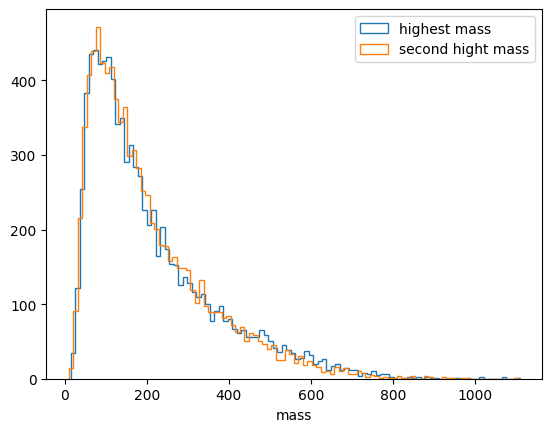

In [36]:
plt.hist(x_masses,bins=100, histtype='step',label='highest mass')
plt.hist(y_masses,bins=100, histtype='step',label='second hight mass')
plt.xlabel('mass')
plt.legend()
plt.show()

In [37]:
first_jets['signal'][2]

PseudoJet(pt=1417.681, eta=-0.721, phi=-0.600, mass=102.632)

In [273]:
print(len(first_jets['background']))
print(f"Jet pt: {first_jets['background'][0].pt}")
print(f"Jet eta: {first_jets['background'][0].eta}")
print(f"Jet phi: {first_jets['background'][0].phi}")
print(f"Jet mass: {first_jets['background'][0].mass}")

9080
Jet pt: 1540.7826399390697
Jet eta: -0.5792274276479966
Jet phi: -1.1388555705535621
Jet mass: 106.94746231707505


In [38]:
constituents = []
rel_constituents = []
len_constituents = []
mask = []
len_padding = 250
for jet in x_jets:
    const_temp = []
    # transform void struct to array
    for constituent_void in jet.constituents_array():
        array = np.asarray(constituent_void).tolist()
        const_temp.append(array)
    unpadded_consts = np.array(const_temp)
    mask_single_jet = np.ones(len(unpadded_consts))
    
    # pad constituents and mask
    padded_mask = np.pad(mask_single_jet,(0,len_padding-len(mask_single_jet)),'constant',constant_values=0)
    padded_consts = np.pad(unpadded_consts,((0,len_padding-len(unpadded_consts)),(0,0)),'constant',constant_values=0)
    
    # relative coordinates
    rel_constituents_temp = padded_consts.copy()
    rel_constituents_temp[:,0] = rel_constituents_temp[:,0]/jet.pt
    rel_constituents_temp[:,1] = rel_constituents_temp[:,1] - jet.eta
    rel_constituents_temp[:,2] = rel_constituents_temp[:,2] - jet.phi
    rel_constituents_temp[:,2] = np.where(rel_constituents_temp[:,2] > np.pi, rel_constituents_temp[:,2] - 2*np.pi, rel_constituents_temp[:,2])
    rel_constituents_temp[:,2] = np.where(rel_constituents_temp[:,2] < -np.pi, rel_constituents_temp[:,2] + 2*np.pi, rel_constituents_temp[:,2])
    
    constituents.append(padded_consts)
    rel_constituents.append(rel_constituents_temp)
    mask.append(padded_mask)
    len_constituents.append(len(jet.constituents_array()))
constituents = np.array(constituents)
rel_constituents = np.array(rel_constituents)
mask = np.array(mask)
print(f"max constituents: {np.max(len_constituents)}")
print(f"min constituents: {np.min(len_constituents)}")
print(constituents.shape)
print(mask.shape)


max constituents: 210
min constituents: 4
(9056, 250, 4)
(9056, 250)


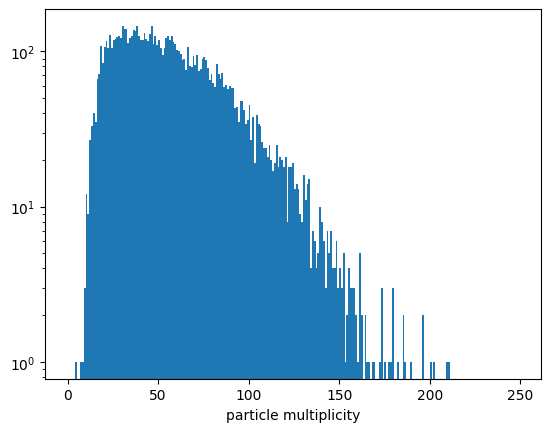

In [39]:
plt.hist(np.sum(mask,axis=-1), bins=range(0,250,1))
plt.xlabel('particle multiplicity')
plt.yscale('log')
plt.show()

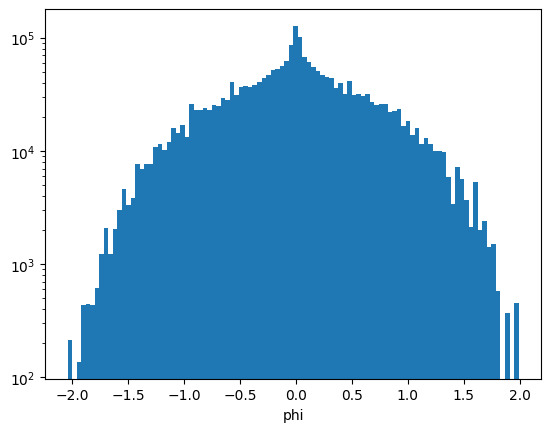

In [41]:
index = 1
plt.hist(rel_constituents[:,:,index].flatten()[rel_constituents[:, :, index].flatten() != 0],bins=100)
plt.xlabel(f'phi')
plt.yscale('log')
plt.show()

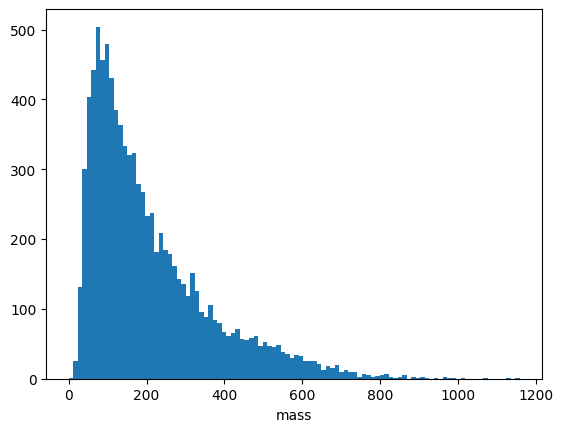

In [22]:
masses = []
for jet in x_jets:
    masses.append(jet.mass)
plt.hist(masses,bins=100)
plt.xlabel('mass')
plt.show()

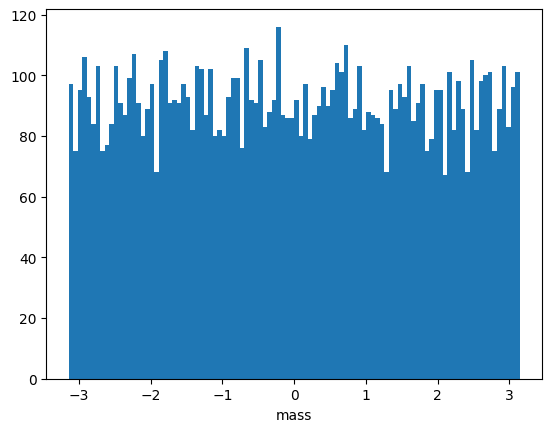

In [25]:
masses = []
for jet in x_jets:
    masses.append(jet.phi)
plt.hist(masses,bins=100)
plt.show()

In [26]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

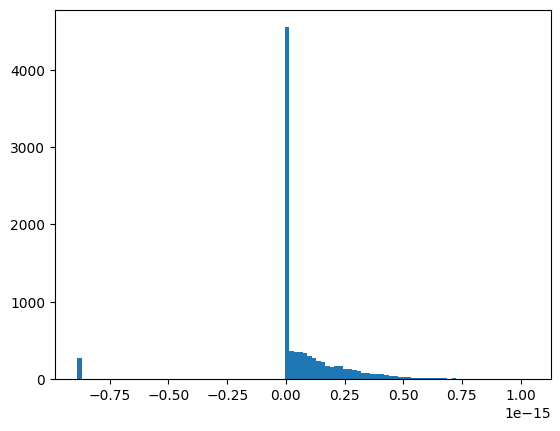

In [36]:
plt.hist(jet_data[:,2],bins=100)
plt.show()

In [83]:
background = alljets["background"]
print(len(background))

9080


In [98]:
print(leadpT["background"])

[1540.7826399390697, 1349.1983343457628, 1354.1409953601947, 1235.272772307667, 1524.065156689483, 1269.9260499772636, 1334.932750194237, 1725.9789655078382, 1338.8525429114397, 1623.084599003053, 1343.558576917352, 1318.9705560534564, 1311.9981846171083, 1216.750701995735, 1403.0995922583513, 1261.1445893762361, 1779.2158081274304, 1358.261416542775, 1219.4855005784402, 1286.8813025471404, 1250.2374218337275, 1590.5789245661013, 1280.7371810903082, 1238.3392831681654, 1262.8998907332343, 1420.9896789868014, 1372.2261322772717, 1398.7286671602853, 1265.2376582143422, 1898.1128759571973, 1402.7050174033097, 1258.4750287064774, 1617.322782476638, 1220.6135581694994, 1476.6641398967445, 1241.478491308405, 1245.4968987363513, 1329.2766418466365, 1458.6272339066873, 1464.702890830904, 1460.2563753239642, 1454.1376690257873, 1229.0555108936314, 1266.6770469381754, 1225.8206492820282, 1213.1576441175507, 1246.034513668485, 1702.6188094861707, 1211.2239035797857, 1210.963653013084, 1402.632249

In [95]:
print(len(background[200]))

3


In [75]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(alljets[mytype])):
        E = alljets[mytype][k][0].e+alljets[mytype][k][1].e
        px = alljets[mytype][k][0].px+alljets[mytype][k][1].px
        py = alljets[mytype][k][0].py+alljets[mytype][k][1].py
        pz = alljets[mytype][k][0].pz+alljets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]
        pass
    pass

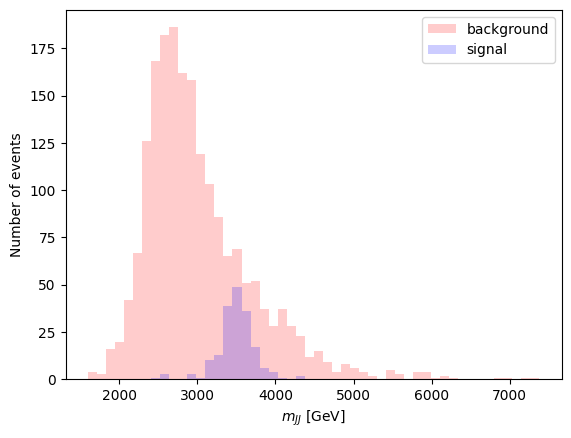

In [76]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.show()

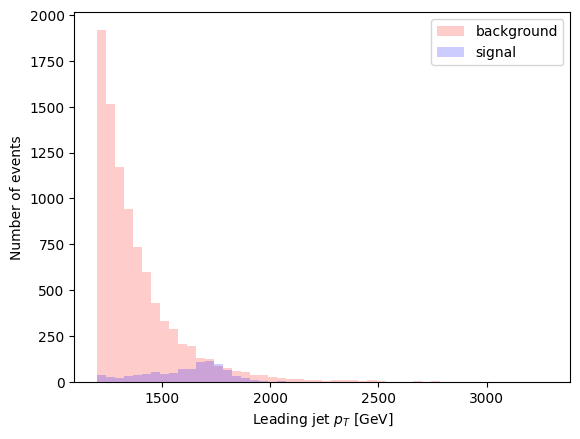

In [97]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.show()

# Fastjet

In [2]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [3]:
# Option 1: Load everything into memory
df = pandas.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [4]:
np_array = np.array(df)
print(np_array.shape)
signal = np_array[np_array[:,2100]==1]
background = np_array[np_array[:,2100]==0]
print(signal.shape)
print(background.shape)

(1100000, 2101)
(100000, 2101)
(1000000, 2101)


In [5]:
background_reduced = background[: , :2100]
signal_reduced = background[: , :2100]
qcd_data = background_reduced.reshape(-1,700,3)
sig_data = signal_reduced.reshape(-1,700,3)
print(qcd_data.shape)
print(sig_data.shape)

(1000000, 700, 3)
(1000000, 700, 3)


In [6]:
print(qcd_data[0,0,:].shape)

(3,)


In [7]:
print(qcd_data[0,0,0])

1.840248942375183


In [8]:
jet = fj.PseudoJet(float(qcd_data[0,0,0]),float(qcd_data[0,0,1]),float(qcd_data[0,0,2]),0.)

In [9]:
data_pseudojets = []
for data in qcd_data[0]:
    data_pseudojets.append(fj.PseudoJet(float(data[0]),float(data[1]),float(data[2]),0.))
print(len(data_pseudojets))

700


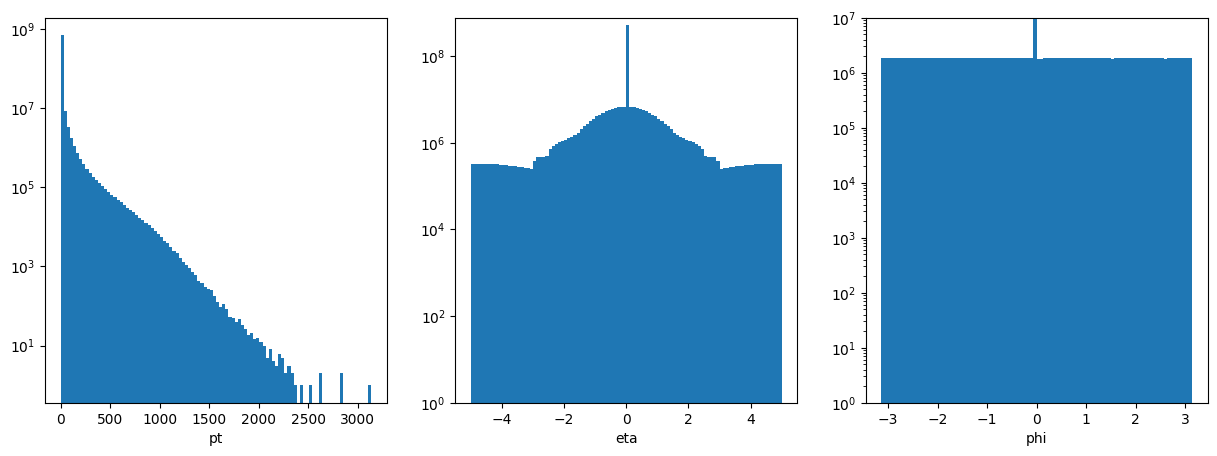

In [10]:
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten(),bins=100#[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
#plt.xlim(-5, 5)
#plt.title("QCD original data")
plt.show()

(1000000, 700, 3)


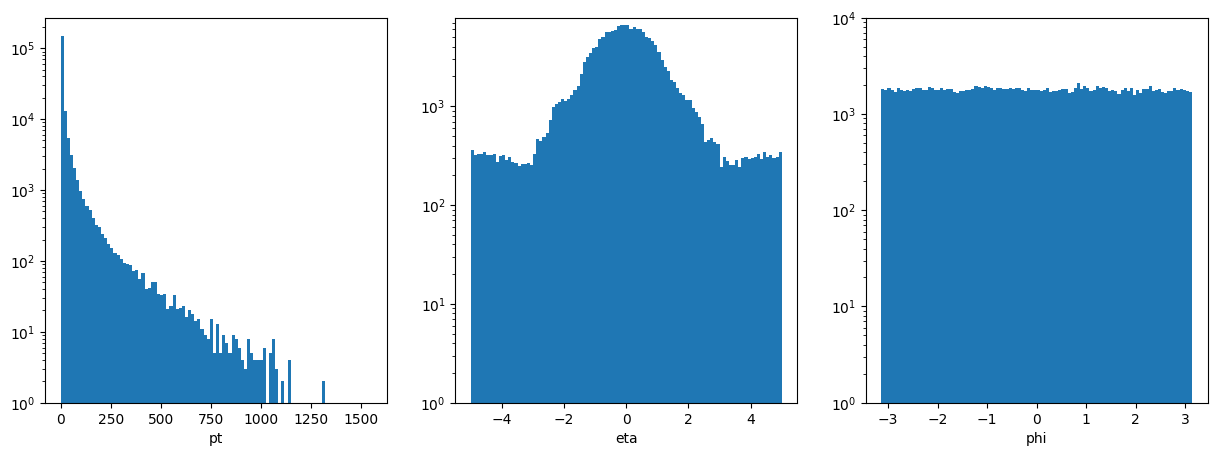

In [11]:
# only take the first 10000 events
print(qcd_data.shape)
qcd_data_small = qcd_data[:1000]
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data_small[:, :, index].flatten()[qcd_data_small[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e4)
#plt.xlim(-5, 5)
#plt.title("QCD original data")

#print((qcd_data_small[5, :120, 0]==0))
#print(qcd_data_small[5, :120 :])
plt.show()

In [12]:
# find the events with pt=0 and eta!=0
pt_0 = qcd_data[:, :, 1]==0
eta_n0 = qcd_data[:, :, 0]!=0
zz = pt_0 == eta_n0
print(zz.sum())

0


In [38]:
find = qcd_data_small[:, :, 0]==2.93086426e+02
find = np.isclose(qcd_data_small[:, :, 0],2.93086426e+02,atol=1e-3)
arg = np.argwhere(find==True)
#print(arg)
event = qcd_data[5, :115, :]
evt_sort = event[np.argsort(event[:, 0])[::-1]]
print(evt_sort)
print(np.count_nonzero(evt_sort[:, 0]))
#2.77260738e-01 -1.69122602e-03 -3.37721332e-03

[[ 3.75192444e+02 -8.39323938e-01  1.96986169e-01]
 [ 3.07613129e+02 -3.86677831e-01 -3.03019071e+00]
 [ 2.93086426e+02 -8.40211213e-01  2.01787099e-01]
 [ 2.69415985e+02 -8.40773284e-01  1.98102474e-01]
 [ 2.41903885e+02 -8.39521289e-01  1.99222326e-01]
 [ 1.55676178e+02 -3.91160995e-01 -3.03091383e+00]
 [ 1.39834488e+02 -3.86865258e-01 -3.01202703e+00]
 [ 9.40050964e+01 -3.83758605e-01 -3.02459240e+00]
 [ 7.94114151e+01  3.27595735e+00  3.05129480e+00]
 [ 5.63879128e+01  2.99277878e+00  3.05537271e+00]
 [ 4.48380814e+01  2.03884363e+00  2.49317789e+00]
 [ 4.39755974e+01  1.74363148e+00 -2.60472941e+00]
 [ 4.04148674e+01 -8.36298585e-01  2.24607781e-01]
 [ 3.87128563e+01 -8.26361716e-01  1.86376736e-01]
 [ 3.18854828e+01 -3.94262493e-01 -2.99811339e+00]
 [ 3.04461861e+01 -8.48331511e-01  2.14565068e-01]
 [ 2.93835316e+01 -3.23378414e-01 -2.47175622e+00]
 [ 2.84285450e+01 -3.14886451e-01 -2.46081305e+00]
 [ 2.51309853e+01  1.80473590e+00 -2.47172952e+00]
 [ 2.13076324e+01  3.12288308e+

In [42]:
# cluster jets
def run(data,n_events=1000):
    
    out = []
    
    # Loop over events
    for ievt in tqdm(range(n_events)):

        # Build a list of all particles
        pjs = []
        for i in range(data.shape[1]):
            #print(data[ievt,i,:])
            if data[ievt,i,0] == 0:
                continue
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data[ievt,i,0],data[ievt,i,1],data[ievt,i,2],0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt()>30.]
        out.append([jets[0],jets[1]])
        #jets = [j for j in jets]
        #out.append(jets)
                
    return out

In [71]:
# test with one event
#print(qcd_data.shape)
one_event = qcd_data_small[5,:700,:][None,:,:]
print(one_event)
out_one = run(one_event,n_events=1)

[[[ 0.28286436 -1.69188249  2.23572803]
  [ 0.64132738 -1.91588295  1.04207122]
  [ 0.59768772 -1.70437729  1.89052081]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

[ 0.28286436 -1.69188249  2.23572803]
[ 0.64132738 -1.91588295  1.04207122]
[ 0.59768772 -1.70437729  1.89052081]
[ 1.71536469 -0.87510246  0.16392915]
[ 3.66794562 -0.87092578  0.23231807]
[16.08651543 -0.79370713  0.19392571]
[ 2.69415985e+02 -8.40773284e-01  1.98102474e-01]
[ 2.41903885e+02 -8.39521289e-01  1.99222326e-01]
[30.44618607 -0.84833151  0.21456507]
[ 3.75192444e+02 -8.39323938e-01  1.96986169e-01]
[ 2.93086426e+02 -8.40211213e-01  2.01787099e-01]
[38.71285629 -0.82636172  0.18637674]
[10.07965374 -0.79836166  0.20124553]
[ 1.58815777 -0.72547674 -0.06948187]
[10.69886017 -0.38128778 -2.98949409]
[155.67617798  -0.39116099  -3.03091383]
[307.61312866  -0.38667783  -3.03019071]
[94.00509644 -0.3837586  -3.0245924 ]
[139.83448792  -0.38686526  -3.01202703]
[31.88548279 -0.39426249 -2.99811339]
[19.65153503 -0.36822113 -3.00667834]
[ 3.5892725  -0.36269024 -2.92841792]
[ 4.63424063 -0.3622658  -2.73048282]
[ 3.21980882 -0.34489721 -2.23136187]
[ 5.75917482 -0.35269994 -2.583

In [74]:
print(len(out_one[0]))
const_pt = []
const_eta = []
for jet in out_one[0]:
    const_pt = np.array([(jet.constituents()[i].perp()) for i in range(len(jet.constituents()))])
    const_eta = np.array([(jet.constituents()[i].pseudorapidity()) for i in range(len(jet.constituents()))])
    const_phi = np.array([(jet.constituents()[i].phi_std()) for i in range(len(jet.constituents()))])

15


In [75]:
print(len(out_one))
x_jet = out_one[0][0]
y_jet = out_one[0][1]
for jet in [x_jet,y_jet]:
    print(jet.constituents()[0])
    print(jet.constituents()[0].py())
    const_pt = np.array([(jet.constituents()[i].perp()) for i in range(len(jet.constituents()))])
    const_eta = np.array([(jet.constituents()[i].pseudorapidity()) for i in range(len(jet.constituents()))])
    const_phi = np.array([(jet.constituents()[i].phi_std()) for i in range(len(jet.constituents()))])
    consts = np.concatenate((const_pt[:,None],const_eta[:,None],const_phi[:,None]),axis=1)
    print(consts)

1
[0.000000, 0.000000, 0.000000, 0.000000]
0.0
[[ 0.00000000e+00  1.00000000e+05  0.00000000e+00]
 [ 1.67619240e+00 -3.83511305e-01  7.42577672e-01]
 [ 8.75093877e-01 -3.33004862e-01  4.19771701e-01]
 [ 1.41495574e+00 -1.20075202e+00 -1.09206617e-01]
 [ 1.58815777e+00 -7.25476742e-01 -6.94818720e-02]
 [ 4.44665575e+00 -8.70012879e-01  4.06829566e-01]
 [ 4.89354181e+00 -7.64914513e-01  2.45367140e-02]
 [ 1.50349259e+00 -6.79826260e-01  1.91885918e-01]
 [ 1.94910729e+00 -7.51675844e-01  2.97488391e-01]
 [ 3.22263145e+00 -7.93649435e-01  2.66154021e-01]
 [ 1.71536469e+00 -8.75102460e-01  1.63929150e-01]
 [ 1.60865154e+01 -7.93707132e-01  1.93925709e-01]
 [ 3.66794562e+00 -8.70925784e-01  2.32318074e-01]
 [ 2.75653410e+00 -8.48282158e-01  2.43766889e-01]
 [ 1.00796537e+01 -7.98361659e-01  2.01245531e-01]
 [ 3.59676886e+00 -8.55851352e-01  2.26882786e-01]
 [ 4.04148674e+01 -8.36298585e-01  2.24607781e-01]
 [ 3.87128563e+01 -8.26361716e-01  1.86376736e-01]
 [ 3.04461861e+01 -8.48331511e-01  

In [39]:
# Actually run
# (this may take a few minutes)
out_qcd = run(qcd_data, n_events=100000)
#out_sig = run(sig_data, n_events=1000)

  5%|▌         | 5498/100000 [00:03<00:59, 1586.62it/s]


KeyboardInterrupt: 

In [21]:
filepath_save_raw = (
        "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2_raw_fastjet_test.h5"
    )

In [20]:
#print(len(out_qcd))
#print(len(out_sig))
#for count, jet in enumerate(out_qcd):
#    #print(count)
#    #print(len(jet))
#    if jet[0].m() > jet[1].m():
#        #print(jet[0].m())
#        #print(jet[1].m())


In [8]:
# separate the leading and subleading jets
jets = out_qcd
x_masses = []
y_masses = []
x_jets = []
y_jets = []
for jets in jets:
    x_jet = jets[0]
    y_jet = jets[1]
    x_jets.append(x_jet)
    y_jets.append(y_jet)
    x_masses.append(x_jet.m())
    y_masses.append(y_jet.m())
x_jets = np.array(x_jets)
y_jets = np.array(y_jets)

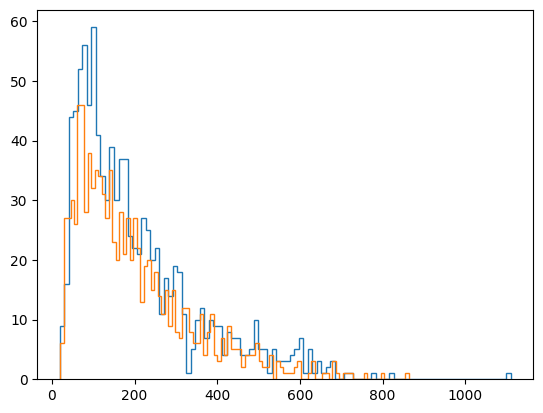

In [9]:
plt.hist(x_masses,bins=100, histtype='step',label='highest mass')
plt.hist(y_masses,bins=100, histtype='step',label='second hight mass')
plt.show()

In [42]:
#print(np.array(x_jets[2].constituents()))
constituents = [(x_jets[2].constituents()[i].m()) for i in range(len(x_jets[2].constituents()))]
print(constituents)

[-2.5809568279517847e-08, 0.0, -2.1073424255447017e-08, 1.0536712127723509e-08, 0.0, 1.0536712127723509e-08, 0.0, 0.0, -5.960464477539063e-08, 0.0, 2.9802322387695312e-08, 0.0, -2.1073424255447017e-08, 0.0, -4.2146848510894035e-08, 1.1920928955078125e-07, 1.1920928955078125e-07, 2.384185791015625e-07, -5.960464477539063e-08, 0.0, -3.371747880871523e-07, 0.0, 1.4600096599955427e-07, 0.0, 0.0, 2.384185791015625e-07, 1.6858739404357614e-07, 0.0, 2.384185791015625e-07, -8.429369702178807e-08, -1.6858739404357614e-07, 3.371747880871523e-07, -1.1920928955078125e-07, 8.429369702178807e-08, -3.371747880871523e-07, 3.371747880871523e-07, -8.429369702178807e-08, 0.0, 1.1920928955078125e-07, 1.1920928955078125e-07, -2.384185791015625e-07, 0.0, 2.384185791015625e-07, 2.9802322387695312e-08, 0.0, 0.0, 0.0, -1.3486991523486091e-06, -4.76837158203125e-07, 6.743495761743046e-07, 2.384185791015625e-07, -3.371747880871523e-07, -6.743495761743046e-07, -1.9073486328125e-06, 1.3486991523486091e-06, 0.0, 0.

In [43]:
array = np.array([1,2,3,4,5,6,7,8,9,10])
print(array[:-1])

[1 2 3 4 5 6 7 8 9]


In [13]:
# get padded constituents, relative coordinates and mask in the wanted format
constituents = []
constituents_xyze = []
rel_constituents = []
mask = []
jet_mass = []
jet_pt = []
jet_eta = []
jet_phi = []
jet_px = []
jet_py = []
jet_pz = []
jet_e = []

len_padding = 300
for jet in tqdm(x_jets):
    # get constituents
    const_pt = np.array([(jet.constituents()[i].perp()) for i in range(len(jet.constituents()))])
    const_eta = np.array([(jet.constituents()[i].pseudorapidity()) for i in range(len(jet.constituents()))])
    const_phi = np.array([(jet.constituents()[i].phi_std()) for i in range(len(jet.constituents()))])
    const_mass = np.array([(jet.constituents()[i].m()) for i in range(len(jet.constituents()))])
    # xyze
    const_px = np.array(
        [(jet.constituents()[i].px()) for i in range(len(jet.constituents()))]
    )
    const_py = np.array(
        [(jet.constituents()[i].py()) for i in range(len(jet.constituents()))]
    )
    const_pz = np.array(
        [(jet.constituents()[i].pz()) for i in range(len(jet.constituents()))]
    )
    const_e = np.array(
        [(jet.constituents()[i].e()) for i in range(len(jet.constituents()))]
    )
    consts = np.concatenate((const_pt[:,None],const_eta[:,None],const_phi[:,None]),axis=1)
    consts_xyze = np.concatenate(
        (const_px[:, None], const_py[:, None], const_pz[:, None], const_e[:, None]),
        axis=1,
    )
    #print(consts)
    # sort constituents by pT from high to low
    consts = consts[np.argsort(consts[:, 0])[::-1]]
    
    #print(len(consts))
    # remove constituents with pT=0
    #while consts[-1,0] == 0:
    #    #print(consts)
    #    consts = consts[:-1]
    #print(consts)
    # pad constituents and mask
    padded_consts = np.pad(consts,((0,len_padding-len(consts)),(0,0)),'constant',constant_values=0)
    padded_consts_xyze = np.pad(
        consts_xyze,
        ((0, len_padding - len(consts_xyze)), (0, 0)),
        "constant",
        constant_values=0,
    )
    padded_mask = np.pad(np.ones(len(consts)),(0,len_padding-len(consts)),'constant',constant_values=0)
    
    # relative coordinates
    rel_constituents_temp = padded_consts.copy()
    rel_constituents_temp[:, 0] = rel_constituents_temp[:, 0] / jet.perp()
    rel_constituents_temp[:, 1] = rel_constituents_temp[:, 1] - jet.rapidity()
    rel_constituents_temp[:, 2] = rel_constituents_temp[:, 2] - jet.phi_std()
    
    # fix phi range
    rel_constituents_temp[:, 2] = np.where(
        rel_constituents_temp[:, 2] >= np.pi,
        rel_constituents_temp[:, 2] - 2 * np.pi,
        rel_constituents_temp[:, 2],
    )
    rel_constituents_temp[:, 2] = np.where(
        rel_constituents_temp[:, 2] <= - np.pi,
        rel_constituents_temp[:, 2] + 2 * np.pi,
        rel_constituents_temp[:, 2],
    )
    
    # jet variables & append to list
    jet_mass.append(jet.m())
    jet_pt.append(jet.perp())
    jet_eta.append(jet.rapidity())
    jet_phi.append(jet.phi_std())
    jet_px.append(jet.px())
    jet_py.append(jet.py())
    jet_pz.append(jet.pz())
    jet_e.append(jet.e())
    constituents.append(padded_consts)
    constituents_xyze.append(padded_consts_xyze)
    rel_constituents.append(rel_constituents_temp)
    mask.append(padded_mask)
mask = np.array(mask)
constituents = np.array(constituents) * mask[:, :, None]
constituents_xyze = np.array(constituents_xyze)
rel_constituents = np.array(rel_constituents)* mask[:, :, None]
jet_mass = np.array(jet_mass)
jet_pt = np.array(jet_pt)
jet_eta = np.array(jet_eta)
jet_phi = np.array(jet_phi)
jet_px = np.array(jet_px)
jet_py = np.array(jet_py)
jet_pz = np.array(jet_pz)
jet_e = np.array(jet_e)

print(constituents.shape)
print(rel_constituents.shape)
print(mask.shape)
print(f"max particle multipilicity: {np.max(np.sum(mask,axis=-1))}")
print(f"min particle multipilicity: {np.min(np.sum(mask,axis=-1))}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 114.76it/s]

(1000, 300, 3)
(1000, 300, 3)
(1000, 300)
max particle multipilicity: 169.0
min particle multipilicity: 8.0


In [71]:
print(np.max(constituents[:,:,3]))
print(np.min(constituents[:,:,3]))

IndexError: index 3 is out of bounds for axis 2 with size 3

In [72]:

plt.hist(constituents[:,:,3],bins=100)
plt.show()

IndexError: index 3 is out of bounds for axis 2 with size 3

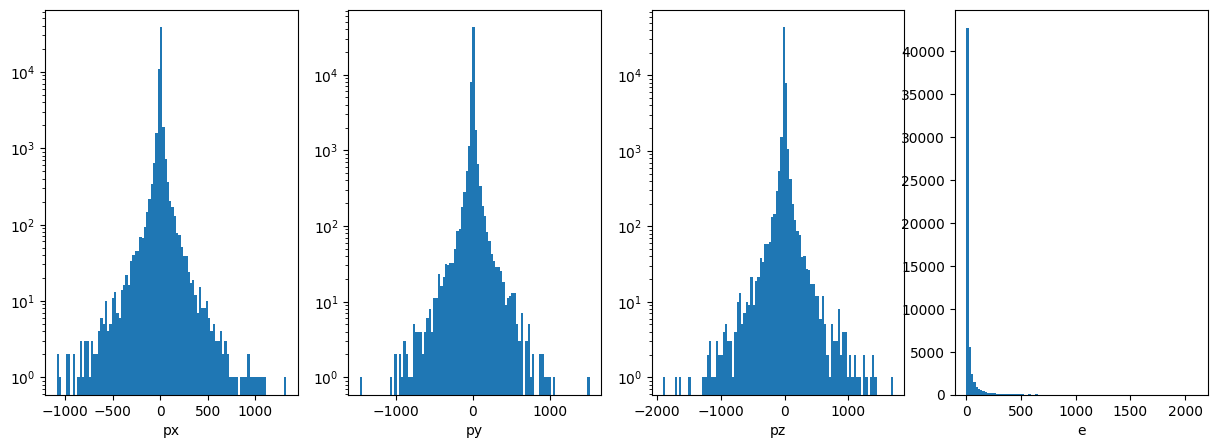

In [14]:
mapp = {"0": "px", "1": "py", "2": "pz", "3": "e"}
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        constituents_xyze[:, :, index].flatten()[constituents_xyze[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
#plt.xlim(-5, 5)
plt.show()

In [15]:
jet_data = np.concatenate((jet_pt[:,None],jet_eta[:,None],jet_phi[:,None],jet_mass[:,None], jet_px[:,None], jet_py[:,None], jet_pz[:,None], jet_e[:,None]),axis=1)
print(jet_data.shape)

(1000, 8)


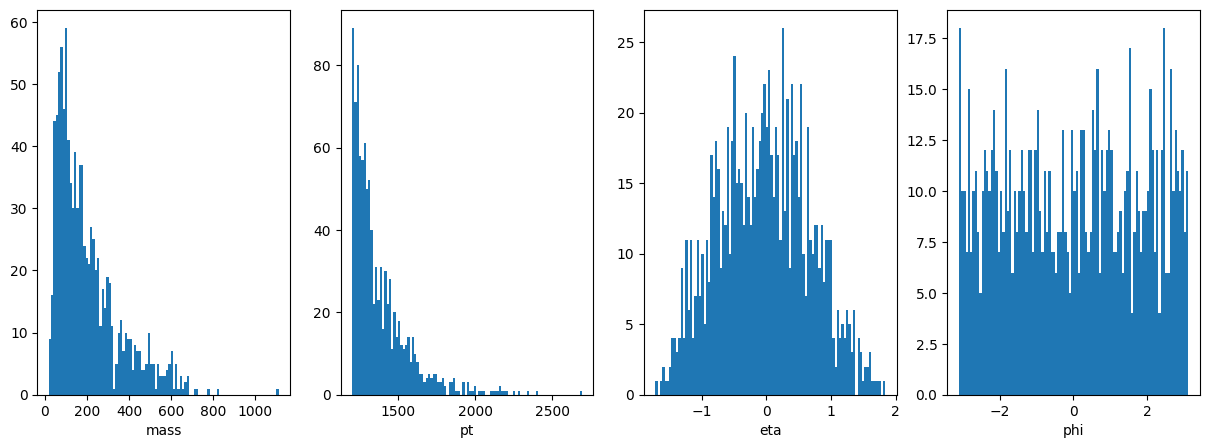

In [16]:
# Leading Jet Clustered Data
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_mass,bins=100)
axs[0].set_xlabel('mass')
axs[1].hist(jet_pt,bins=100)
axs[1].set_xlabel('pt')
axs[2].hist(jet_eta,bins=100)
axs[2].set_xlabel('eta')
axs[3].hist(jet_phi,bins=100)
axs[3].set_xlabel('phi')
plt.show()

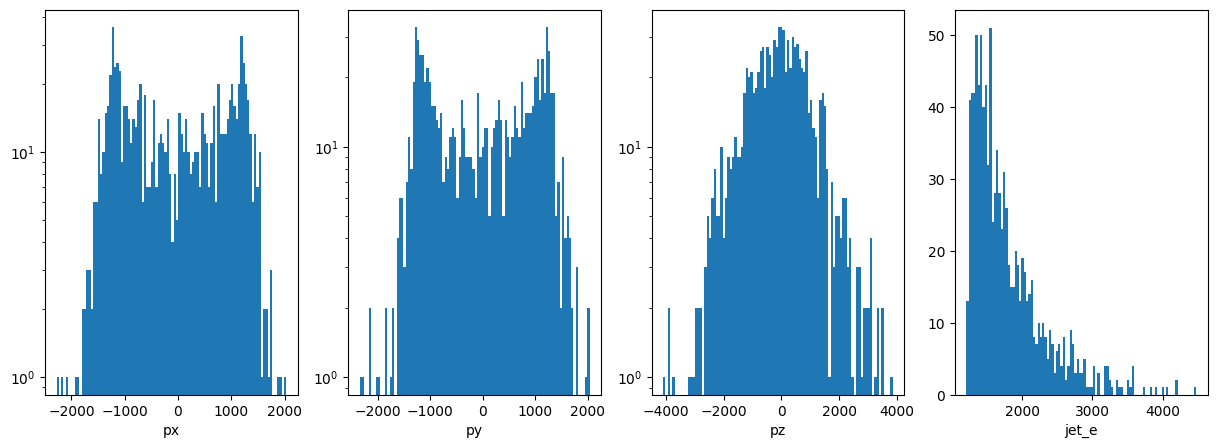

In [17]:
# Leading Jet Clustered Data
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_px,bins=100)
axs[0].set_xlabel('px')
axs[0].set_yscale('log')
axs[1].hist(jet_py,bins=100)
axs[1].set_xlabel('py')
axs[1].set_yscale('log')
axs[2].hist(jet_pz,bins=100)
axs[2].set_xlabel('pz')
axs[2].set_yscale('log')
axs[3].hist(jet_e,bins=100)
axs[3].set_xlabel('jet_e')
plt.show()

In [18]:
print(np.count_nonzero(constituents[5,:,0]))
print(constituents[5,:25])
print(rel_constituents[5,:25])

23
[[ 3.75192444e+02 -8.39323938e-01  1.96986169e-01]
 [ 2.93086426e+02 -8.40211213e-01  2.01787099e-01]
 [ 2.69415985e+02 -8.40773284e-01  1.98102474e-01]
 [ 2.41903885e+02 -8.39521289e-01  1.99222326e-01]
 [ 4.04148674e+01 -8.36298585e-01  2.24607781e-01]
 [ 3.87128563e+01 -8.26361716e-01  1.86376736e-01]
 [ 3.04461861e+01 -8.48331511e-01  2.14565068e-01]
 [ 1.60865154e+01 -7.93707132e-01  1.93925709e-01]
 [ 1.00796537e+01 -7.98361659e-01  2.01245531e-01]
 [ 5.16797829e+00 -8.28773320e-01  2.08990559e-01]
 [ 4.89354181e+00 -7.64914513e-01  2.45367140e-02]
 [ 4.44665575e+00 -8.70012879e-01  4.06829566e-01]
 [ 3.66794562e+00 -8.70925784e-01  2.32318074e-01]
 [ 3.59676886e+00 -8.55851352e-01  2.26882786e-01]
 [ 3.22263145e+00 -7.93649435e-01  2.66154021e-01]
 [ 2.75653410e+00 -8.48282158e-01  2.43766889e-01]
 [ 1.94910729e+00 -7.51675844e-01  2.97488391e-01]
 [ 1.71536469e+00 -8.75102460e-01  1.63929150e-01]
 [ 1.67619240e+00 -3.83511305e-01  7.42577672e-01]
 [ 1.58815777e+00 -7.2547674

In [19]:
print(mask[5,:25])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0.]


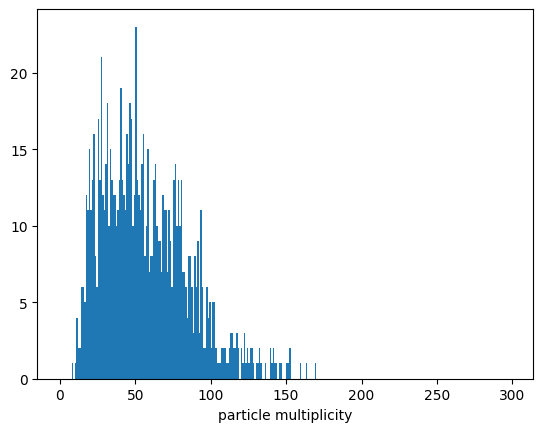

In [20]:
plt.hist(np.sum(mask,axis=-1), bins=range(0,300,1))
plt.xlabel('particle multiplicity')
plt.show()

In [21]:
# remove weird eta values
counter=0
for count_i,i in enumerate(rel_constituents):
    for count_j, j in enumerate(i):
        if j[1] > 1000:
            counter +=1
            print(count_i, count_j, j)
            rel_constituents[count_i,count_j,1] = 0
            rel_constituents[count_i,count_j,2] = 0
            mask[count_i,count_j] = 0
            print(rel_constituents[count_i,count_j,1])
        #else:
            #print(count_i, count_j, j[1])
print(counter)

0


In [22]:
# remove weird eta values
counter=0
for count_i,i in enumerate(constituents):
    for count_j, j in enumerate(i):
        if j[1] > 1000:
            counter +=1
            print(count_i, count_j, j)
            constituents[count_i,count_j,1] = 0
            constituents[count_i,count_j,2] = 0
            print(constituents[count_i,count_j,1])
        #else:
            #print(count_i, count_j, j[1])
print(counter)

0


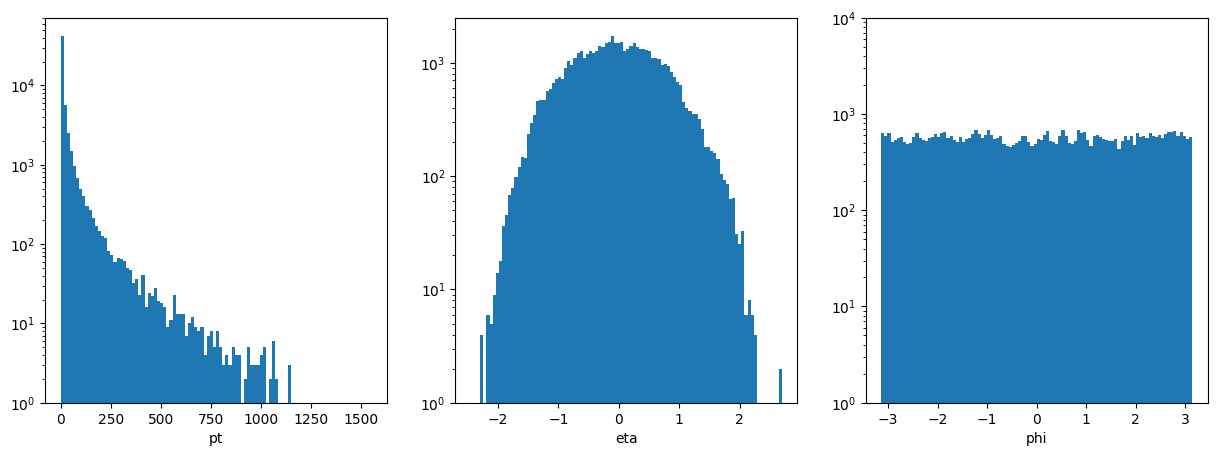

In [23]:

mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        constituents[:, :, index].flatten()[constituents[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e4)
#plt.xlim(-5, 5)
plt.show()

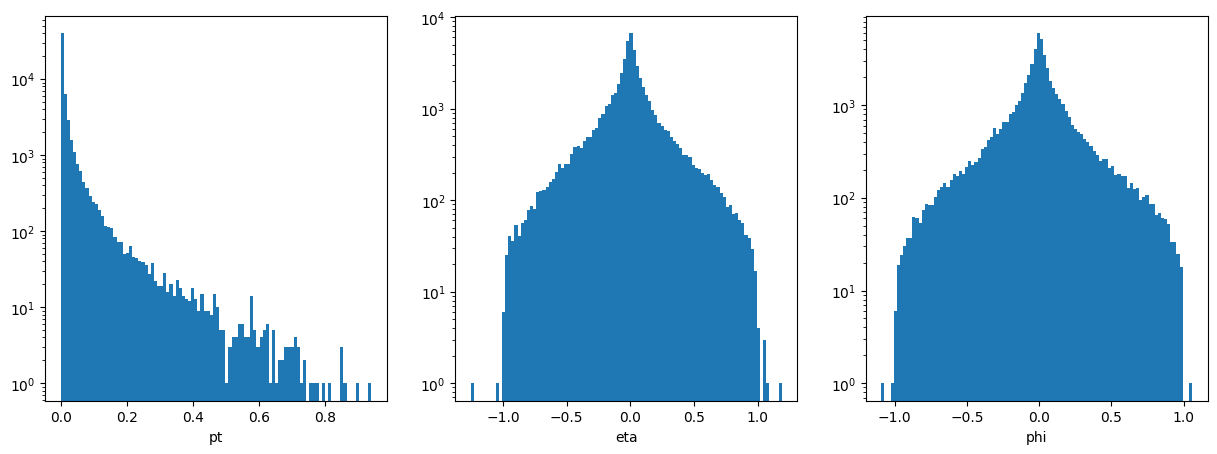

In [24]:
mapp = {"0": "pt", "1": "eta", "2": "phi"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        rel_constituents[:, :, index].flatten()[rel_constituents[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
#plt.xlim(-5, 5)
plt.show()

In [25]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data_calc = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

0.9999999999999988
1.0000000000000016


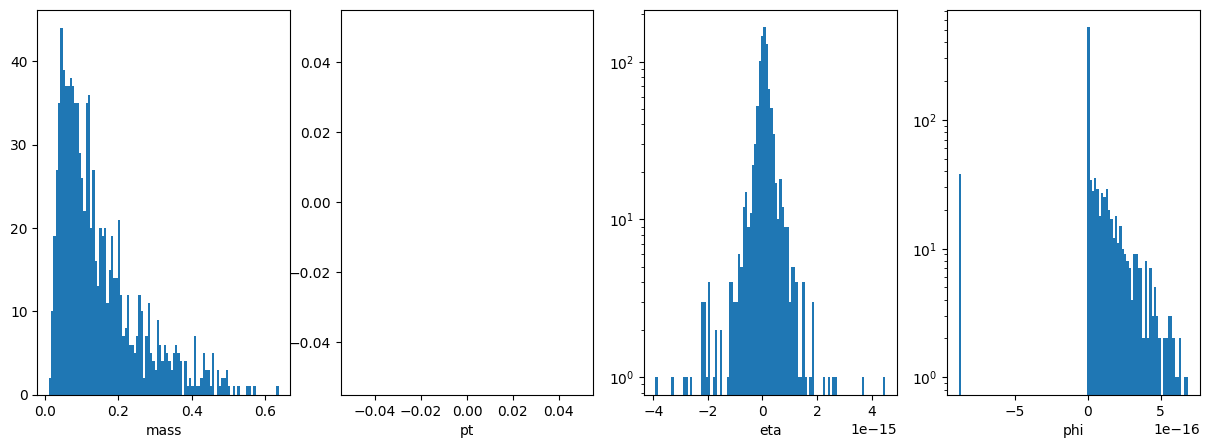

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_data_calc[:,3],bins=100)
axs[0].set_xlabel('mass')
binwidth = 10
print(min(jet_data_calc[:,0]))
print(max(jet_data_calc[:,0]))
axs[1].hist(jet_data_calc[:,0],bins=np.arange(0.99,1.01,0.1))
axs[1].set_xlabel('pt')
axs[2].hist(jet_data_calc[:,1],bins=100)
axs[2].set_xlabel('eta')
axs[2].set_yscale('log')
axs[3].hist(jet_data_calc[:,2],bins=100)
axs[3].set_xlabel('phi')
axs[3].set_yscale('log')
plt.show()

In [27]:
p4s_nr = ef.p4s_from_ptyphims(constituents[:, :, :3])
sum_p4_nr = np.sum(p4s_nr, axis=-2)
jet_data_nr = ef.ptyphims_from_p4s(sum_p4_nr, phi_ref=0)

1200.0473511711996
2694.002622385111


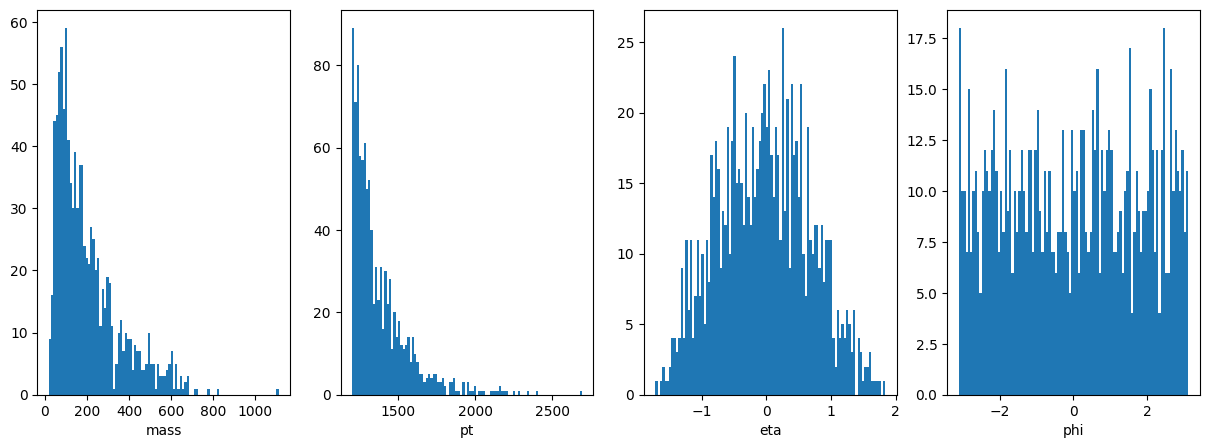

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_data_nr[:,3],bins=100)
axs[0].set_xlabel('mass')
print(min(jet_data_nr[:,0]))
print(max(jet_data_nr[:,0]))
axs[1].hist(jet_data_nr[:,0],bins=100)
axs[1].set_xlabel('pt')
axs[2].hist(jet_data_nr[:,1],bins=100)
axs[2].set_xlabel('eta')
axs[3].hist(jet_data_nr[:,2],bins=100)
axs[3].set_xlabel('phi')
plt.show()

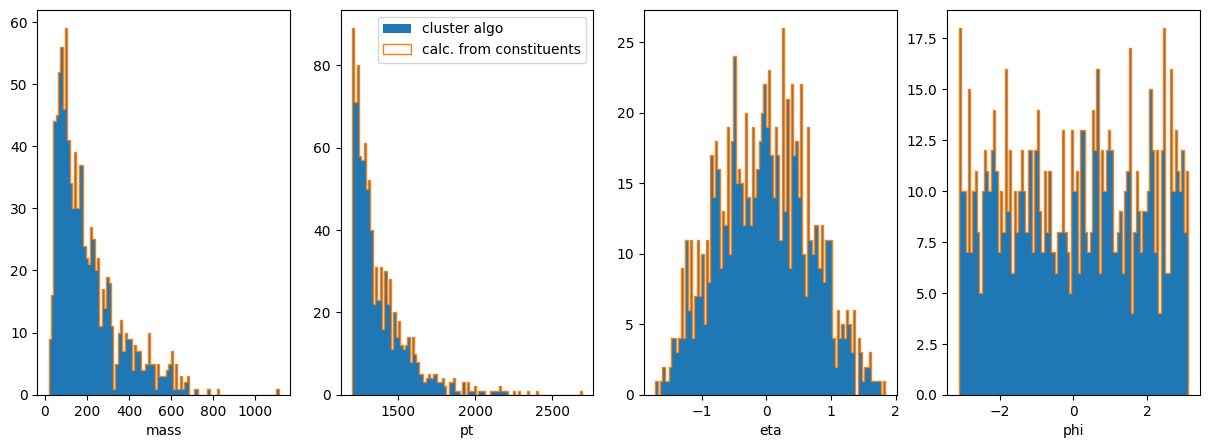

In [29]:
# Leading Jet Clustered Data
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(jet_mass,bins=100)
axs[0].hist(jet_data_nr[:,3],bins=100, histtype='step')
axs[0].set_xlabel('mass')
axs[1].hist(jet_pt,bins=100, label='cluster algo')
axs[1].hist(jet_data_nr[:,0],bins=100, histtype='step', label="calc. from constituents")
axs[1].set_xlabel('pt')
axs[1].legend()
axs[2].hist(jet_eta,bins=100)
axs[2].hist(jet_data_nr[:,1],bins=100, histtype='step')
axs[2].set_xlabel('eta')
axs[3].hist(jet_phi,bins=100)
axs[3].hist(jet_data_nr[:,2],bins=100, histtype='step')
axs[3].set_xlabel('phi')
plt.show()

## Compare to features

In [30]:
path = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.features.h5"
df = pandas.read_hdf(path)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))
feats = np.array(df)
background_feats = feats[feats[:, 14] == 0]
background_feats = background_feats[:1000, :14]

(1100000, 15)
Memory in GB: 0.13113021850585938


In [31]:
# calculate 4-vector from self clustered
p4s_gen = ef.p4s_from_ptyphims(jet_data_nr[:, :4])[:,[1,2,3,0]]
p4s_gen = sum_p4_nr[:,[1,2,3,0]]

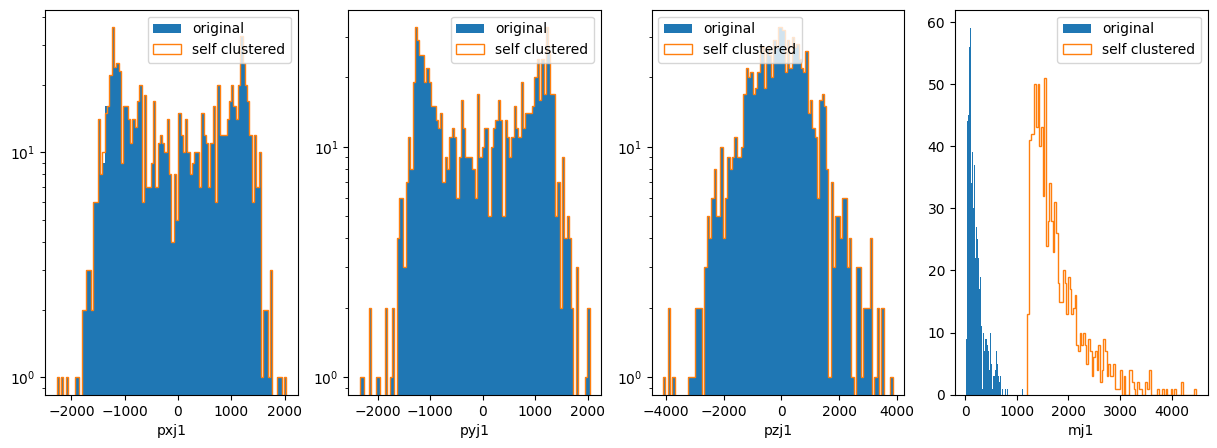

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        np.array(background_feats[:, index]).flatten()[np.array(background_feats[:, index]).flatten() != 0], bins=100, label='original'
    )
    ax.hist(
        np.array(p4s_gen[:, index]).flatten()[np.array(p4s_gen[:, index]).flatten() != 0], bins=100, label='self clustered', histtype="step"
    )
    ax.legend()
    ax.set_xlabel(f"{df.columns[index]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
plt.show()

In [33]:
diff_p4 = np.array(background_feats[:, :4]) - np.array(p4s_gen[:, :4])

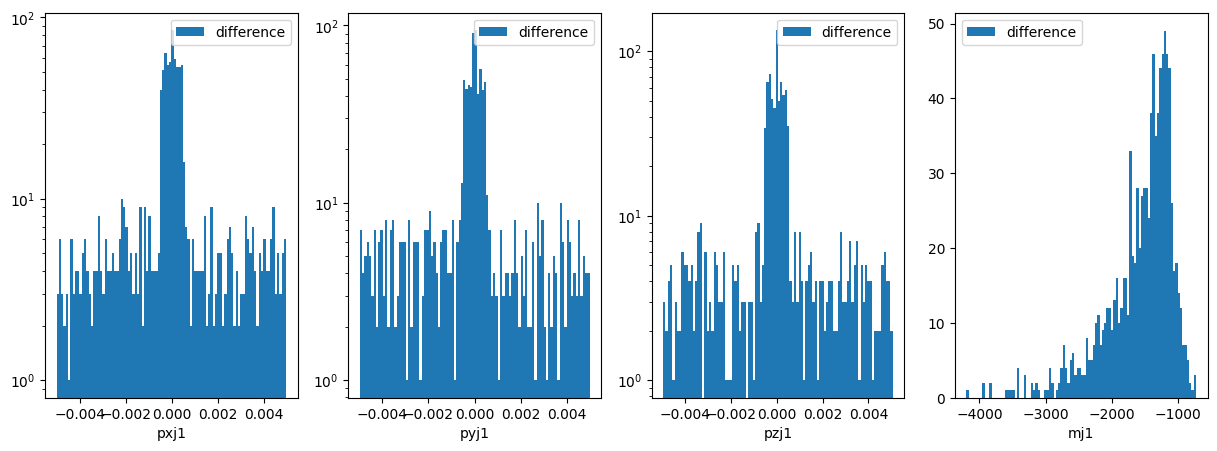

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        np.array(diff_p4[:, index]).flatten()[np.array(diff_p4[:, index]).flatten() != 0], bins=100, label='difference'
    )
    ax.legend()
    ax.set_xlabel(f"{df.columns[index]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
plt.show()

In [35]:
print(jet_data.shape)

(1000, 8)


(1000, 4)


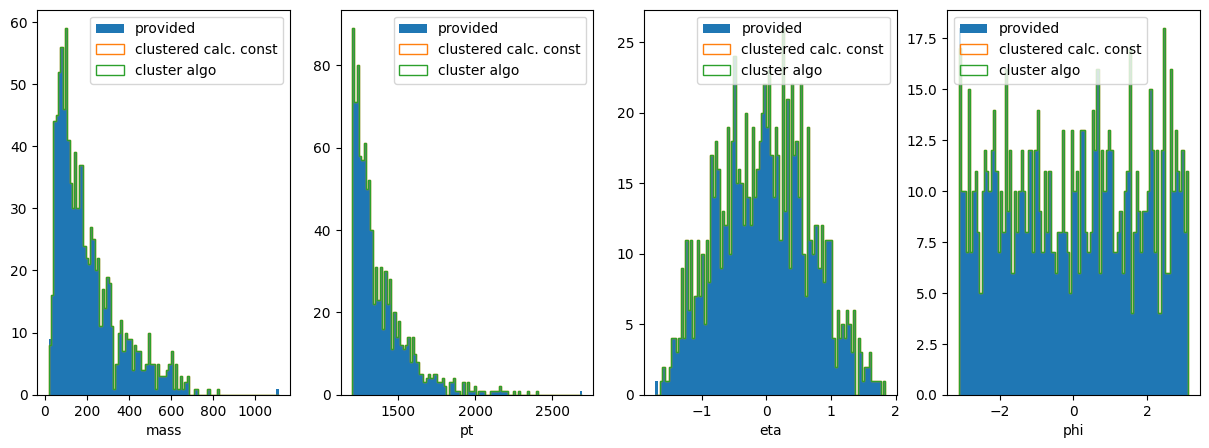

In [36]:
mapp = {"1": "pt", "2": "eta", "3": "phi", "0": "mass"}
p3 = background_feats[:, :3]
e = np.sqrt(background_feats[:, 0]**2 + background_feats[:, 1]**2 + background_feats[:, 2]**2 + background_feats[:, 3]**2)
#print(e)
p4 = np.concatenate((e[:, None],p3), axis=1)
jet_data_ptetaphi = ef.ptyphims_from_p4s(p4, phi_ref=0)
#print(jet_data_ptetaphi)
jet_data_ptetaphi = jet_data_ptetaphi[:, [3,0,1,2]]
jet_data_nr1 = jet_data_nr[:, [3,0,1,2]]
jet_data_1 = jet_data[:, [3,0,1,2]]

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
print(jet_data_nr1.shape)
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        jet_data_ptetaphi[:, index].flatten()[jet_data_ptetaphi[:, index].flatten() != 0], bins=100, label="provided"
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    
    ax.hist(jet_data_nr1[:,index],bins=hist1[1], histtype='step', label="clustered calc. const")
    ax.hist(jet_data_1[:,index],bins=hist1[1], histtype='step', label="cluster algo")
    ax.legend()
    
    #if index == 1:
    #    ax.set_yscale("log")
    #if index ==2:
    #    ax.set_ylim(1,1e5)
    #else:
    #    ax.set_ylim(1,)
#diff = jet_data_ptetaphi - jet_data_nr1
#print(diff)

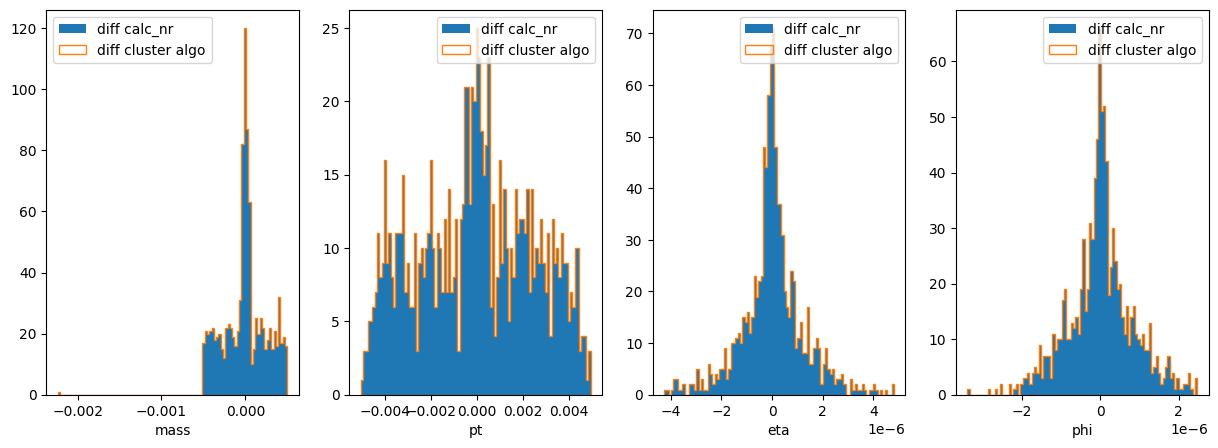

In [37]:
diff_calc_nr = jet_data_ptetaphi - jet_data_nr1
diff_algo = jet_data_ptetaphi - jet_data_1
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        diff_calc_nr[:, index].flatten()[diff_calc_nr[:, index].flatten() != 0], bins=100, label="diff calc_nr"
    )
    ax.set_xlabel(f"{mapp[str(index)]}")
    
    ax.hist(diff_algo[:,index],bins=100, histtype='step', label="diff cluster algo")
    ax.legend()

# Load data

In [8]:
path = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2_processed_fastjet_testsignal.h5"
with h5py.File(path, "r") as f:
    print(f.keys())
    #rel_constituents = f["data"][:]
    #mask = f["mask"][:]

<KeysViewHDF5 ['constituents_x', 'constituents_y', 'jet_data_x', 'jet_data_y', 'mask_x', 'mask_y', 'rel_constituents_x', 'rel_constituents_y']>


In [4]:
print(rel_constituents.shape)
print(mask.shape)

(1000, 300, 3)
(1000, 300)


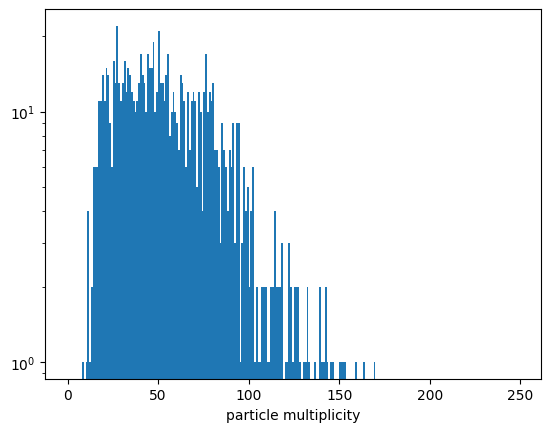

In [5]:
plt.hist(np.sum(mask, axis=-1), bins=range(0, 250, 1))
plt.xlabel("particle multiplicity")
plt.yscale("log")
plt.show()

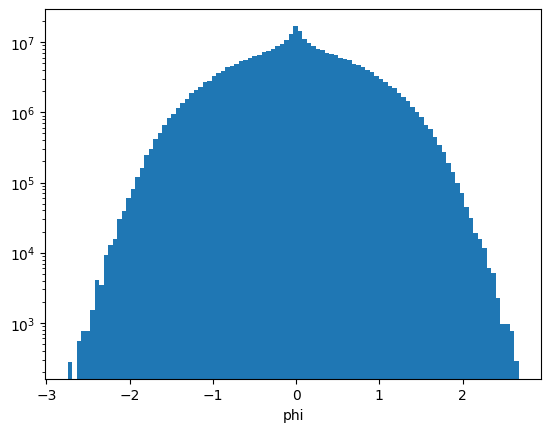

In [46]:
index = 1
plt.hist(
    rel_constituents[:, :, index].flatten()[rel_constituents[:, :, index].flatten() != 0], bins=100
)
plt.xlabel("phi")
plt.yscale("log")
plt.show()

In [41]:
p4s = ef.p4s_from_ptyphims(rel_constituents[:, :, :3])
sum_p4 = np.sum(p4s, axis=-2)
jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)

In [42]:
jet_data.shape

(1000000, 4)

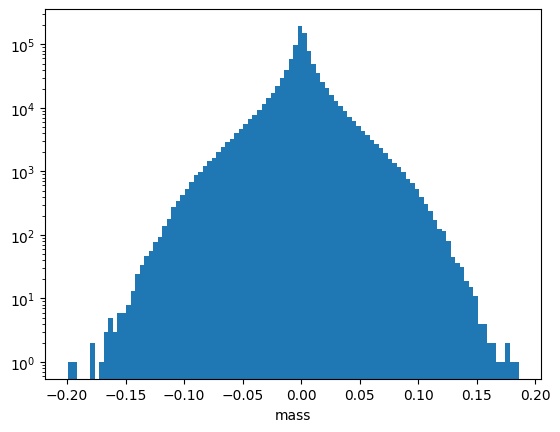

In [43]:
plt.hist(jet_data[:, 1], bins=100)
plt.yscale("log")
plt.xlabel("mass")
# plt.xlim(0.1+1e-12-1e-11,0.1+1e-12+1e-11)
plt.show()

In [44]:
data = rel_constituents[:, :, :3]
print(data.shape)

(1000000, 300, 3)


In [45]:
data2 = np.concatenate([data, np.expand_dims(mask, axis=-1)], axis=-1)
print(data2.shape)

(1000000, 300, 4)
